# Solar wind interaction with Lunar magnetic anomalies

## Set up environment and configure setting

In [1]:
#Smilei job
# ! qdel 2538
# ! spack env activate smilei-oneapi && $HOME/Smilei/build/smilei-oneapi/smilei test.py
# ! qsub $HOME/pic/zijin_oneapi.pbs -V 
# ! showq && qstat

In [2]:
import happi
import yt
from _utils import *
from icecream import ic
from parameters import *

yt.set_log_level(40)

In [3]:
v_sw

unyt_quantity(350000., 'm/s')

### Set metadata

In [4]:
dimensions = 3
# Set fields metadata: Ex Ey Ez Bx By Bz Bx_m By_m Bz_m Jx Jy Jz Rho Jx_solar_ion Jy_solar_ion Jz_solar_ion Rho_solar_ion Jx_solar_electron Jy_solar_electron Jz_solar_electron Rho_solar_electron
rho_fields_yt = ["Rho_solar_electron", "Rho_solar_ion"]
rho_fields_smilei = ["-Rho_solar_electron", "Rho_solar_ion"]
rho_units = ["dimensionless"] * 2  # rho_units = ['kg/m**3', 'kg/m**3']
rho_labels = [r"$\rho_{solar-electron}$", r"$\rho_{solar-ion}$"]

B_fields_yt = ["magnetic_field_x", "magnetic_field_y", "magnetic_field_z"]
B_fields_smilei = ["Bx", "By", "Bz"]
B_units = ["dimensionless"] * dimensions
B_labels = [r"$B_{x}$", r"$B_{y}$", r"$B_{z}$"]

E_fields_yt = ["electric_field_x", "electric_field_y", "electric_field_z"]
E_fields_smilei = ["Ex", "Ey", "Ez"]
# E_units = [E_r, E_r, E_r]
E_units = ["dimensionless"] * dimensions
E_labels = [r"$E_{x}$", r"$E_{y}$", r"$E_{z}$"]


fields_smilei = [*B_fields_smilei, *E_fields_smilei, *rho_fields_smilei]
fields_yt = [*B_fields_yt, *E_fields_yt, *rho_fields_yt]
fields_units = [*B_units, *E_units, *rho_units]


### class `SmileiPostProcessing`

In [5]:
SPP = SmileiPostProcessing(
    fields_smilei=fields_smilei,
    fields_yt=fields_yt,
    fields_units=fields_units,
)
S= SPP.SmileiSimulation
# SPP.print_simulation()

bbox = [
    [0, grid_length[0]],
    [-grid_length[1] / 2, grid_length[1] / 2],
    [-grid_length[2] / 2, grid_length[2] / 2],
] * L_r
timesteps = S.Field(0, fields_smilei[0]).getTimesteps().astype(int)

In [17]:
def TrackParticles(S):
    '''
    >>> TrackParticles(S)
    '''
    track={}
    for species in S.namelist.Species:  
        track[species.name] = S.TrackParticles(species =species.name,axes = ["x","y","z","px","py","pz","Id"])
        # track[species].plot()
    pass
    # track[species.name] = S.TrackParticles(species =species.name,axes = ["x","px"])

# Diag = S.TrackParticles(species="solar_electron", select=[1, 2, 3], axes=["x","px"])
# select = "any(t>0, (y>" + str(1/2*grid_length[1]-2*cell_length[1]) + ")*(y<" + str(1/2*grid_length[1]+2*cell_length[1]) + ")*(z>" + str(1/2*grid_length[2]-2*cell_length[2]) + ")*(z<" + str(1/2*grid_length[2]+2*cell_length[2]) + "))"
# Diag = S.TrackParticles(species="solar_electron", select= select, axes=["x","px"])
# data=Diag.getData()
# ic(select)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 19390414 but corresponding boolean dimension is 19390406

In [6]:
# select = "any(t>=0, (x>" + str(1/2*grid_length[0]-2*cell_length[0]) + ")*(x<" + str(1/2*grid_length[0]+2*cell_length[0]) + "))"
# ic(select)
# select = "any(t>=0, (x>0.29296875)*(x<0.33203125))"
# diag = S.TrackParticles(species ="solar_ion", select=select, axes = ["x", "y"], timesteps=0)
# diag.plot()
# diag.plot(axes = ["x", "px"])

In [7]:
# Diag.plot(timestep=timesteps[-10])

In [8]:
# import h5py
# f = h5py.File("TrackParticles_solar_ion.h5", "r")
# ic(f['Bx'])
# for _key in f['data']['0000000000'].keys():
#     print(f['data']['0000000000'][_key])

In [9]:
# ad = f.all_data()
# phaseplot_z = yt.ParticlePhasePlot(ad, 
#                                    'particle_position_x', 
#                                    'particle_position_y', 
#                                    'particle_weighting',
#                                   )
# phaseplot_z.set_unit('particle_position_x', unit='um')
# phaseplot_z.set_unit('particle_position_y', unit='um')
# phaseplot_z.set_xlim(ad["particle_position_x"].max())
# phaseplot_z.set_ylim(ad["particle_position_y"].max())

# phaseplot_z.show()
# particle_phase_space_y = yt.ParticlePlot(multiple_species, 
#                                          ('all', 'particle_position_y'), 
#                                          ('all', 'particle_momentum_y'), 
#                                          ('all', 'particle_weighting'),
#                                          x_bins=800,
#                                          y_bins=800)

## Set up `yt`

In [10]:
import numpy as np
import yt
from yt import derived_field
from unyt.dimensions import length
from unyt import m

### Set derived_field

In [11]:
@derived_field(
    name=("stream", "magnetic_field_strength"),
    units="dimensionless",
    sampling_type="cell",
)
def _magnetic_field_strength(field, data):
    return np.sqrt(
        data["stream", "magnetic_field_x"] ** 2
        + data["stream", "magnetic_field_y"] ** 2
        + data["stream", "magnetic_field_z"] ** 2
    )

@derived_field(
    name=("stream", "electric_field_strength"),
    units="dimensionless",
    sampling_type="cell",
)
def _magnetic_field_strength(field, data):
    return np.sqrt(
        data["stream", "electric_field_x"] ** 2
        + data["stream", "electric_field_y"] ** 2
        + data["stream", "electric_field_z"] ** 2
    )


### Load data

In [12]:
def getData(timestep):
    data = {}
    for field_yt, field_smilei in zip(fields_yt, fields_smilei):
        data[field_yt] = S.Field(0, field_smilei).getData(timestep=timestep)[0]
    domain_dimensions = data[fields_yt[0]].shape
    data = {k: (v, u) for (k, v), u in zip(data.items(), fields_units)}
    ds = yt.load_uniform_grid(
        data,
        domain_dimensions,
        length_unit="m",
        bbox=bbox,
        nprocs=24,
        sim_time=timestep,
        periodicity=(False, False, False),
        unit_system="mks",
    )
    ds.timestep = timestep
    ds.unit_registry.add("d_i", float(d_i), length, tex_repr="d_i")
    return ds


## Plot Fields

### Plot 2-D species density profiles

Two-dimensional (top) electron and (bottom) ion charge density profiles, scaled to the initial density, $n_{sw}$ ,and along the dipole axis (Y direction) at z = 0 after the simulation has reached quasi-steady state. The solar wind is flowing perpendicular (in the −X direction) to the lunar surface. Superimposed in black are magnetic field lines.

In [13]:
def plot_density_profile_2D_yt(ds, axis="z"):
    slc = yt.SlicePlot(
        ds, axis, [("stream", field) for field in rho_fields_yt], origin="native"
    )
    slc.set_axes_unit("d_i")
    slc.annotate_timestamp()
    for field, label in zip(rho_fields_yt, rho_labels):
        slc.set_colorbar_label(("stream", field), label)
        slc.set_log(("stream", field), False)
        slc.set_cmap(("stream", field), "doom_r")
    if axis == "y":
        fig = slc.export_to_mpl_figure((2, 1))
    else:
        fig = slc.export_to_mpl_figure((1, 2))

    fig.tight_layout()
    fig.savefig(
        "figures/"
        + "rho/yt_rho_"
        + axis
        + "_"
        + str(ds.timestep).zfill(10)
    )
    return fig


In [14]:
def plot_density_profile_2D_happi():
    def rho_transform(rho):
        return rho / S.namelist.n_solar

    # subset
    Rho_solar_electron_z0 = S.Field(
        0,
        "-Rho_solar_electron",
        subset={"z": grid_length[2] / 2},
        data_transform=rho_transform,
        title=r"$\rho_{solar-electron}$",
    )
    Rho_solar_ion_z0 = S.Field(
        0,
        "Rho_solar_ion",
        subset={"z": grid_length[2] / 2},
        data_transform=rho_transform,
        title=r"$\rho_{solar-ion}$",
    )
    happi.multiPlot(
        Rho_solar_electron_z0,
        Rho_solar_ion_z0,
        shape=[1, 2],
        saveAs="figures/rho/rho_sub_",
    )
    # average
    Rho_solar_electron_z0 = S.Field(
        0,
        "-Rho_solar_electron",
        average={"z": "all"},
        data_transform=rho_transform,
        title=r"$\rho_{solar-electron}$",
    )
    Rho_solar_ion_z0 = S.Field(
        0,
        "Rho_solar_ion",
        average={"z": "all"},
        data_transform=rho_transform,
        title=r"$\rho_{solar-ion}$",
    )
    happi.multiPlot(
        Rho_solar_electron_z0,
        Rho_solar_ion_z0,
        shape=[1, 2],
        saveAs="figures/rho/rho_avg_",
    )


### Plot 1-D species density profiles
Profiles along the direction parallel to the solar wind flow and through the center of the dipole. The upper panel presents the density profiles, normalized to the initial density $n_{sw}$. The remaining panels hold the magnetic and kinetic pressure profiles for the electron (middle) and ion (bottom) populations, in code units.

In [15]:
def plot_density_profile_1D_happi(timestep):
    def rho_transform(rho):
        return rho / S.namelist.n_solar

    data = {}
    for field, label in zip(rho_fields_smilei, rho_labels):
        data[field] = S.Field(
            0,
            field,
            timesteps=timestep,
            label=label,
            subset={"z": grid_length[2] / 2, "y": grid_length[2] / 2},
            data_transform=rho_transform,
            xlabel=r"Distance above the surface ($d_i$)",
            xmin=grid_length[0],
            xmax=0,
            ylabel=r"$\rho$",
        )
    return happi.multiPlot(
        *[data[field] for field in rho_fields_smilei],
        saveAs="figures/rho/rho_sub_1D_"
    )


### Plot magnetic field

In [16]:
def plot_mag_field_yt(ds, axis="z"):
    slc = yt.SlicePlot(
        ds,
        axis,
        [("stream", "magnetic_field_strength")]
        + [("stream", field) for field in B_fields_yt],
        origin="native",
    )
    slc.set_axes_unit("d_i")
    slc.set_colorbar_label(("stream", "magnetic_field_strength"), r"$B_m$")
    for field, label in zip(B_fields_yt, B_labels):
        slc.set_colorbar_label(("stream", field), label)
        slc.set_log(("stream", field), False)
    fig = slc.export_to_mpl_figure((2, 2))
    fig.tight_layout()
    fig.savefig("figures/B/yt_B_" + str(ds.timestep).zfill(10))
    return fig


In [17]:
def plot_mag_field_happi():
    B_0 = S.Field(0, "(Bx**2+By**2+Bz**2)**0.5", subset={"z": grid_length[2] / 2})
    B_x0 = S.Field(0, "Bx", subset={"z": grid_length[2] / 2})
    B_y0 = S.Field(0, "By", subset={"z": grid_length[2] / 2})
    B_z0 = S.Field(0, "Bz", subset={"z": grid_length[2] / 2})
    # figure(figsize=(12, 12))
    happi.multiPlot(
        B_0,
        B_x0,
        B_y0,
        B_z0,
        shape=[2, 2],
        saveAs="figures/B/smilei_B__",
    )


#### Plot magnetic field streamlines

In [18]:
def plot_streamlines(ds):
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    from yt.visualization.api import Streamlines

    # Define c: the center of the box, N: the number of streamlines,
    # scale: the spatial scale of the streamlines relative to the boxsize,
    # and then pos: the random positions of the streamlines.
    c = ds.domain_center
    N = 100
    scale = ds.domain_width[0]
    pos_dx = np.random.random((N, 3)) * scale - scale / 2.0
    pos = c + pos_dx

    streamlines = Streamlines(
        ds,
        pos,
        ("stream", "Bx"),
        ("stream", "By"),
        ("stream", "Bz"),
    )
    streamlines.integrate_through_volume()

    # Create a 3D plot, trace the streamlines through the 3D volume of the plot
    fig = plt.figure()
    ax = Axes3D(fig, auto_add_to_figure=False)
    fig.add_axes(ax)
    for stream in streamlines.streamlines:
        stream = stream[np.all(stream != 0.0, axis=1)]
        ax.plot3D(stream[:, 0], stream[:, 1], stream[:, 2])

    # Save the plot to disk.
    plt.savefig("streamlines.png")


### Plot electric field

In [19]:
def plot_electric_field_yt(ds, axis="z"):
    slc = yt.SlicePlot(
        ds, axis, [("stream", "electric_field_strength")]+ [("stream", field) for field in E_fields_yt], origin="native"
    )
    slc.set_axes_unit("d_i")
    for field, label in zip(E_fields_yt, E_labels):
        slc.set_colorbar_label(("stream", field), label)
        slc.set_log(("stream", field), False)
    fig = slc.export_to_mpl_figure((2, 2))
    fig.tight_layout()
    fig.savefig("figures/E/yt_E_" + str(ds.timestep).zfill(10))
    return fig


## Plot gyroradius

In [20]:
from astropy import units as u
from astropy.constants import m_e
from plasmapy.formulary import gyroradius
from plasmapy.particles import Particle, CustomParticle

electron = Particle("e-")
ion = CustomParticle(mass=S.namelist.m_ion * m_e, charge=1)


def plot_gyroradii_1D(timestep):
    pxx = S.ParticleBinning("pxx", sum={"x": "all", "y": "all"})
    pyy = S.ParticleBinning("pyy", sum={"x": "all", "y": "all"})
    v_perp = 0.0
    m = 0.0
    q = 0.0
    B = 0.0

    r_g_solar_electron = gyroradius(B, electron, v_perp)
    r_g_solar_ion = gyroradius(B, ion, v_perp)
    pass


/home/zijin/mambaforge/lib/python3.9/site-packages/plasmapy/particles/particle_class.py:2130: UserWarning: CustomParticle charge set to 1 times the elementary charge.
  warnings.warn(


## Plot plasma beta

In [21]:
from astropy import units as u
from plasmapy.formulary import beta

def T():

    pass

def plot_beta_1D(timestep):
    """
    Plot the
    """
    T = u.K
    n = u.m**-3
    B = u.T
    beta(T, n, B)
    pass


## Plot velocity distribution

In [19]:
def plot_electric_drift_1D(timestep):
    pass


def plot_magnetic_drift_1D(timestep):
    pass


/home/zijin/Smilei/happi/_Diagnostics/Diagnostic.py:852: RuntimeWarning: divide by zero encountered in log10
  return self._np.log10( self._vfactor*self._getDataAtTime(t) )


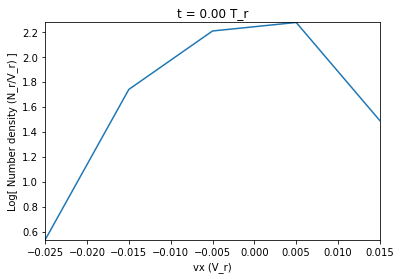

/home/zijin/Smilei/happi/_Diagnostics/Diagnostic.py:852: RuntimeWarning: divide by zero encountered in log10
  return self._np.log10( self._vfactor*self._getDataAtTime(t) )


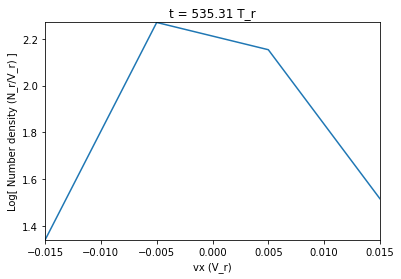

/home/zijin/Smilei/happi/_Diagnostics/Diagnostic.py:852: RuntimeWarning: divide by zero encountered in log10
  return self._np.log10( self._vfactor*self._getDataAtTime(t) )


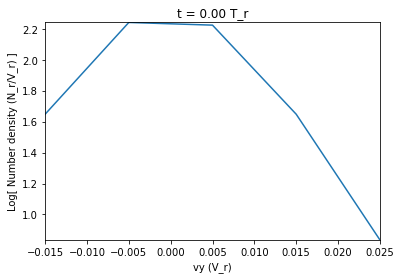

/home/zijin/Smilei/happi/_Diagnostics/Diagnostic.py:852: RuntimeWarning: divide by zero encountered in log10
  return self._np.log10( self._vfactor*self._getDataAtTime(t) )


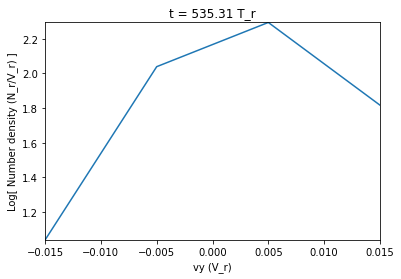

/home/zijin/Smilei/happi/_Diagnostics/Diagnostic.py:852: RuntimeWarning: divide by zero encountered in log10
  return self._np.log10( self._vfactor*self._getDataAtTime(t) )


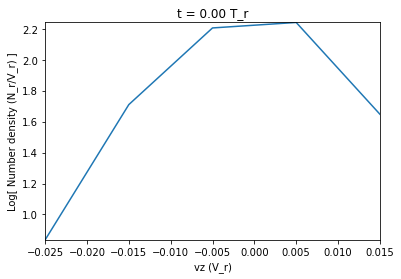

/home/zijin/Smilei/happi/_Diagnostics/Diagnostic.py:852: RuntimeWarning: divide by zero encountered in log10
  return self._np.log10( self._vfactor*self._getDataAtTime(t) )


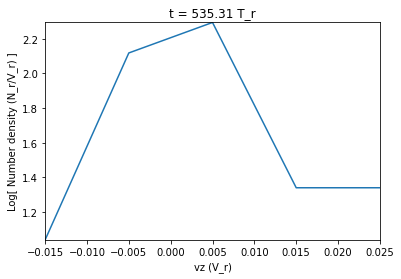

/home/zijin/Smilei/happi/_Diagnostics/Diagnostic.py:852: RuntimeWarning: divide by zero encountered in log10
  return self._np.log10( self._vfactor*self._getDataAtTime(t) )


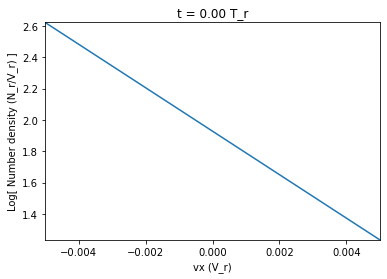

/home/zijin/Smilei/happi/_Diagnostics/Diagnostic.py:852: RuntimeWarning: divide by zero encountered in log10
  return self._np.log10( self._vfactor*self._getDataAtTime(t) )


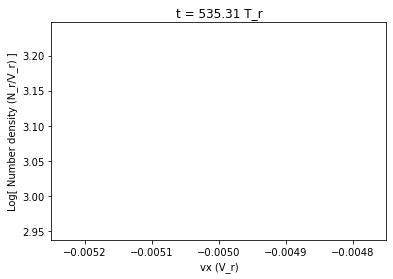

/home/zijin/Smilei/happi/_Diagnostics/Diagnostic.py:852: RuntimeWarning: divide by zero encountered in log10
  return self._np.log10( self._vfactor*self._getDataAtTime(t) )


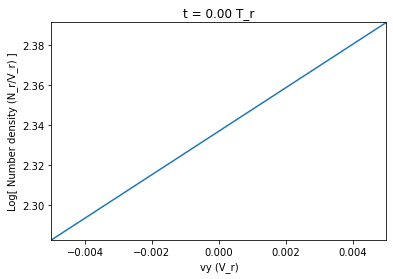

/home/zijin/Smilei/happi/_Diagnostics/Diagnostic.py:852: RuntimeWarning: divide by zero encountered in log10
  return self._np.log10( self._vfactor*self._getDataAtTime(t) )


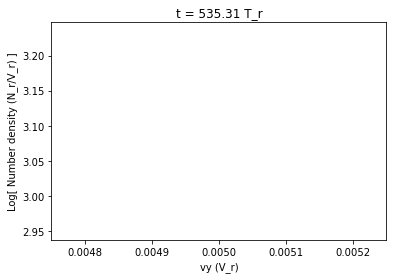

/home/zijin/Smilei/happi/_Diagnostics/Diagnostic.py:852: RuntimeWarning: divide by zero encountered in log10
  return self._np.log10( self._vfactor*self._getDataAtTime(t) )


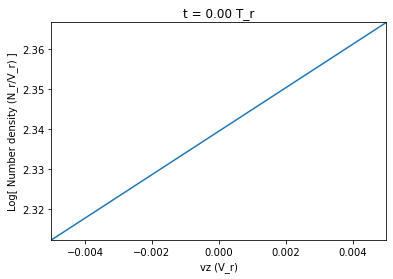

/home/zijin/Smilei/happi/_Diagnostics/Diagnostic.py:852: RuntimeWarning: divide by zero encountered in log10
  return self._np.log10( self._vfactor*self._getDataAtTime(t) )


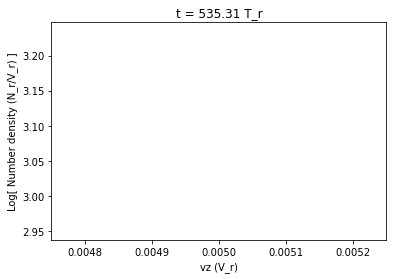

In [33]:
def plot_particle_distribution_vx_vy_vz_happi(timestep=0, center=0):
    ''' use `happi` to visualize particle distribution
    >>> plot_particle_distribution_x_vx_vy_vz_happi()
    '''
    Nt = S.ParticleBinning(0).getTimesteps()[-1] # the last timestep
    diag_numbers = S.getDiags("ParticleBinning")[0][-1]+1
    # diag_numbers = 1
    for diag in range(diag_numbers):
        f_initial = S.ParticleBinning(diag, data_log= True, timesteps=0, sum = {"x": "all", "y" : "all", "z" : "all"})
        f_final   = S.ParticleBinning(diag, data_log= True, timesteps=Nt, sum = {"x": "all","y" : "all", "z" : "all"})
        # f_initial.plot(xmin=-0.025, xmax=0.025)
        # f_final.plot(xmin=-0.025, xmax=0.025)
        # happi.multiPlot(f_initial, f_final, saveas='figures/DiagParticleBinning')
        f_initial.plot()
        f_final.plot()
    pass

plot_particle_distribution_vx_vy_vz_happi()


In [8]:
import numpy as np
import pandas as pd
import xarray as xr

def plot_particle_distribution_x_vx_vy_vz_happi(timestep=None):
    ''' use `happi` to visualize particle distribution
    >>> plot_particle_distribution_x_vx_vy_vz_happi()
    '''
    Nt = S.ParticleBinning(0).getTimesteps()[-1] # the last timestep
    # diag_numbers = S.getDiags("ParticleBinning")[0][-1]+1
    diag_numbers = 1
    for diag in range(diag_numbers):
        f_initial = S.ParticleBinning(diag, data_log= True, timesteps=0 , label="initial", sum = {"y" : "all", "z" : "all"})
        f_final   = S.ParticleBinning(diag, data_log= True, timesteps=Nt, label="final", sum = {"y" : "all", "z" : "all"})
        happi.multiPlot(f_initial, f_final, saveas='figures/DiagParticleBinning')
        # f_initial.plot()
        # f_final.plot()
    pass

def plot_particle_distribution_x_vx_vy_vz_proplot(timestep=None):
    '''use `xarray` and `proplot` to visualize particle distribution
    >>> plot_particle_distribution_x_vx_vy_vz_proplot()
    '''
    Nt = S.ParticleBinning(0).getTimesteps()[-1] # the last timestep
    diag_numbers = S.getDiags("ParticleBinning")[0][-1]+1
    diag=0
    data = S.ParticleBinning(diag,sum = {"y" : "all", "z" : "all"}).getData()
    ic(np.array(data).shape)
    data = xr.DataArray(data, dims=("timestep", "x", "vx"))
    data2d = data.isel(0)
    data2d.plot()


## Visualize the tracked macro-particles

## Job

In [20]:
# ts = {timestep: getData(timestep) for timestep in timesteps}
# plot_mag_field_yt(ts[0])
# plot_species_density_z_yt(ts[0])
# plot_density_profile_1D_happi(timesteps[0])

# SPP.plot_scalar()
# plot_density_profile_2D_happi()
# plot_mag_field_happi()
# [plot_mag_field_yt(ds) for ds in ts.values()]
# [plot_electric_field_yt(ds) for ds in ts.values()]

# %time [plot_density_profile_2D_yt(ds, "z") for ds in ts.values()]
# %time [plot_density_profile_2D_yt(ds, "y") for ds in ts.values()]
# %time [plot_density_profile_2D_yt(ds, "x") for ds in ts.values()]
# [plot_density_profile_1D_happi(timestep) for timestep in timesteps]

# %time Parallel(n_jobs=2)(delayed(plot_mag_field_yt)(ds) for ds in ts.values())
# %time Parallel(n_jobs=2)(delayed(plot_density_profile_1D_happi)(timestep) for timestep in timesteps)


#TODO Parallel visualization in python

## Code test

No handles with labels found to put in legend.


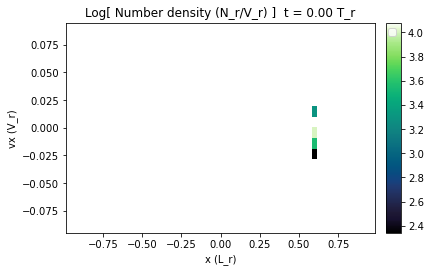

No handles with labels found to put in legend.


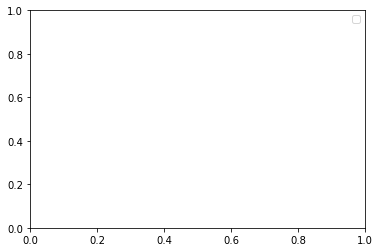

TestResults(failed=0, attempted=1)

In [9]:
import doctest

doctest.testmod()